# Model-1 (Baseline Model):

### Cell-1: 

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Progress tracking and logging
from tqdm import tqdm
import logging

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Starting data preprocessing...")

# Load dataset
data_path = "Urban-Computing/Data 2021.xlsx"  # Replace with actual dataset path
data = pd.read_excel(data_path)
logging.info(f"Data loaded successfully with shape {data.shape}")

# Parse 'Date' column into datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.sort_values(by='Date', inplace=True)
logging.info("Date column parsed and data sorted.")

# Handle missing values using forward fill
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)
logging.info("Missing values handled with forward and backward fill.")

# Normalize percentage-based columns and population columns
percentage_columns = [
    'retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline',
    'walking', 'driving'
]

population_columns = ['Population']

scaler = MinMaxScaler()
data[percentage_columns] = scaler.fit_transform(data[percentage_columns])
data[population_columns] = scaler.fit_transform(data[population_columns])
logging.info("Normalization of percentage-based and population columns completed.")

# Split data into training and testing sets
train_size = 0.7
train_data, test_data = train_test_split(data, test_size=(1 - train_size), shuffle=False)

logging.info(f"Data split into training and testing sets: Training shape {train_data.shape}, Testing shape {test_data.shape}.")

# Save preprocessed data for downstream use
train_data.to_excel("Urban-Computing/train_data.xlsx", index=False)
test_data.to_excel("Urban-Computing/test_data.xlsx", index=False)
logging.info("Preprocessed training and testing datasets saved successfully.")


2025-01-10 11:05:45,497 - INFO - Starting data preprocessing...


FileNotFoundError: [Errno 2] No such file or directory: 'Urban-Computing/Data 2021.xlsx'

### Cell-2:

In [1]:
# Import necessary libraries
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse_sklearn, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import logging
from tqdm import tqdm
import pandas as pd

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Starting model training...")

# Load preprocessed training and testing data
train_data = pd.read_excel("Urban-Computing/train_data.xlsx")
test_data = pd.read_excel("Urban-Computing/test_data.xlsx")

# Extract features and target variables
X_train = train_data.drop(columns=['Date', 'Country', 'Cases', 'Deaths'])
y_train_cases = train_data['Cases']
y_train_deaths = train_data['Deaths']

X_test = test_data.drop(columns=['Date', 'Country', 'Cases', 'Deaths'])
y_test_cases = test_data['Cases']
y_test_deaths = test_data['Deaths']

# Ensure data scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check for missing values
if X_train.isnull().sum().sum() > 0 or X_test.isnull().sum().sum() > 0:
    logging.error("Missing values detected in the dataset.")
    raise ValueError("Please preprocess the data to remove missing values.")

# Initialize and configure the AutoML regressor with increased time
model_cases = AutoSklearnRegressor(
    time_left_for_this_task=7200,  # Total time for the AutoML process (2 hours)
    per_run_time_limit=600,  # Time per individual model run (10 minutes)
    n_jobs=1,  # Use single core for execution
    memory_limit=10240,  # Memory limit in MB
    metric=mean_squared_error
)

model_deaths = AutoSklearnRegressor(
    time_left_for_this_task=7200,  # Total time for the AutoML process (2 hours)
    per_run_time_limit=600,  # Time per individual model run (10 minutes)
    n_jobs=1,  # Use single core for execution
    memory_limit=10240,  # Memory limit in MB
    metric=mean_squared_error
)

# Train the models
logging.info("Training model for case predictions...")
model_cases.fit(X_train_scaled, y_train_cases)
logging.info("Training model for death predictions...")
model_deaths.fit(X_train_scaled, y_train_deaths)

# Save model training statistics
with open("Urban-Computing/model_cases_stats.txt", "w") as f:
    f.write(model_cases.sprint_statistics())
with open("Urban-Computing/model_deaths_stats.txt", "w") as f:
    f.write(model_deaths.sprint_statistics())

# Make predictions
logging.info("Making predictions for test data...")
pred_cases = model_cases.predict(X_test_scaled)
pred_deaths = model_deaths.predict(X_test_scaled)

# Evaluate performance
logging.info("Evaluating performance...")
rmse_cases = np.sqrt(mse_sklearn(y_test_cases, pred_cases))
mae_cases = mean_absolute_error(y_test_cases, pred_cases)

rmse_deaths = np.sqrt(mse_sklearn(y_test_deaths, pred_deaths))
mae_deaths = mean_absolute_error(y_test_deaths, pred_deaths)

logging.info(f"Cases Prediction - RMSE: {rmse_cases}, MAE: {mae_cases}")
logging.info(f"Deaths Prediction - RMSE: {rmse_deaths}, MAE: {mae_deaths}")

# Save predictions and results
results = pd.DataFrame({
    'Country': test_data['Country'],
    'Date': test_data['Date'],
    'True_Cases': y_test_cases,
    'Pred_Cases': pred_cases,
    'True_Deaths': y_test_deaths,
    'Pred_Deaths': pred_deaths
})

results.to_excel("Urban-Computing/prediction_results.xlsx", index=False)
logging.info("Predictions and results saved successfully.")

2025-01-09 22:03:05,516 - INFO - Starting model training...
2025-01-09 22:03:06,108 - INFO - Training model for case predictions...


[WARNING] [2025-01-09 22:03:11,224:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2025-01-09 22:03:14,837:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2025-01-09 22:03:15,997:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2025-01-09 22:03:16,703:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2025-01-09 22:03:20,907:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2025-01-09 22:03:25,483:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WAR

/data/s4017633/env/uc/lib/python3.7/site-packages/sklearn/metrics/_regression.py:338: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/data/s4017633/env/uc/lib/python3.7/site-packages/sklearn/metrics/_regression.py:338: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/data/s4017633/env/uc/lib/python3.7/site-packages/sklearn/metrics/_regression.py:338: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/data/s4017633/env/uc/lib/python3.7/site-packages/sklearn/metrics/_regression.py:338: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/data/s4017633/env/uc/lib/python3.7/site-packages/sklearn/metrics/_regression.py:338: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/data/s4017633/env/uc/lib/pyth

### Updated Cell-2:

In [ ]:
# Import necessary libraries
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_absolute_error as mae_scorer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import logging
from tqdm import tqdm

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Starting baseline model training with progress tracking...")

# Load preprocessed data
data = pd.read_excel("Urban-Computing/train_data.xlsx")

# Feature engineering: Add rolling averages and lags for time series data
data['Cases_RollingMean'] = data['Cases'].rolling(window=7).mean().fillna(method='bfill')
data['Deaths_RollingMean'] = data['Deaths'].rolling(window=7).mean().fillna(method='bfill')
data['Cases_Lag'] = data['Cases'].shift(1).fillna(0)
data['Deaths_Lag'] = data['Deaths'].shift(1).fillna(0)

# Extract features and target variables
features = data.drop(columns=['Date', 'Country', 'Cases', 'Deaths'])
target_cases = data['Cases']
target_deaths = data['Deaths']

# Split data into training and testing sets
X_train, X_test, y_train_cases, y_test_cases = train_test_split(features, target_cases, test_size=0.3, shuffle=False)
X_train, X_test, y_train_deaths, y_test_deaths = train_test_split(features, target_deaths, test_size=0.3, shuffle=False)

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize AutoML regressors
model_cases = AutoSklearnRegressor(
    time_left_for_this_task=10800,  # Total time for AutoML process (3 hours)
    per_run_time_limit=600,  # Time per individual model run (10 minutes)
    n_jobs=1,  # Utilize all available CPU cores
    memory_limit=20480,  # Increased memory limit in MB
    metric=mae_scorer,  # Correctly use the Auto-Sklearn scorer
    ensemble_size=50  # Increase ensemble size for better performance
)

model_deaths = AutoSklearnRegressor(
    time_left_for_this_task=10800,
    per_run_time_limit=600,
    n_jobs=1,
    memory_limit=20480,
    metric=mae_scorer,
    ensemble_size=50
)

# Train the models with progress tracking
logging.info("Training model for case predictions...")
with tqdm(total=100, desc="Training Case Model", unit="%") as pbar:
    model_cases.fit(X_train_scaled, y_train_cases)
    for _ in range(100):
        pbar.update(1)  # Update progress bar step by step

logging.info("Training model for death predictions...")
with tqdm(total=100, desc="Training Death Model", unit="%") as pbar:
    model_deaths.fit(X_train_scaled, y_train_deaths)
    for _ in range(100):
        pbar.update(1)

# Save model training statistics
with open("Urban-Computing/model_cases_stats.txt", "w") as f:
    f.write(model_cases.sprint_statistics())
with open("Urban-Computing/model_deaths_stats.txt", "w") as f:
    f.write(model_deaths.sprint_statistics())

# Make predictions
logging.info("Making predictions for test data...")
pred_cases = model_cases.predict(X_test_scaled)
pred_deaths = model_deaths.predict(X_test_scaled)

# Evaluate performance
logging.info("Evaluating performance...")
rmse_cases = np.sqrt(mean_squared_error(y_test_cases, pred_cases))
mae_cases = mean_absolute_error(y_test_cases, pred_cases)
r2_cases = r2_score(y_test_cases, pred_cases)

rmse_deaths = np.sqrt(mean_squared_error(y_test_deaths, pred_deaths))
mae_deaths = mean_absolute_error(y_test_deaths, pred_deaths)
r2_deaths = r2_score(y_test_deaths, pred_deaths)

logging.info(f"Cases Prediction - RMSE: {rmse_cases}, MAE: {mae_cases}, R2: {r2_cases}")
logging.info(f"Deaths Prediction - RMSE: {rmse_deaths}, MAE: {mae_deaths}, R2: {r2_deaths}")

# Save predictions and results
results = pd.DataFrame({
    'Country': data['Country'][len(data) - len(y_test_cases):],  # Extract matching rows
    'Date': data['Date'][len(data) - len(y_test_cases):],
    'True_Cases': y_test_cases,
    'Pred_Cases': pred_cases,
    'True_Deaths': y_test_deaths,
    'Pred_Deaths': pred_deaths
})

results.to_excel("Urban-Computing/predictions_results_updated.xlsx", index=False)
logging.info("Baseline predictions and results saved successfully.")


2025-01-10 04:13:54,536 - INFO - Starting baseline model training with progress tracking...
/data/s4017633/env/uc/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `ensemble_size` has been deprecated, please use `ensemble_kwargs = {'ensemble_size': 50}`. Inserting `ensemble_size` into `ensemble_kwargs` for now. `ensemble_size` will be removed in auto-sklearn 0.16.
/data/s4017633/env/uc/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `ensemble_size` has been deprecated, please use `ensemble_kwargs = {'ensemble_size': 50}`. Inserting `ensemble_size` into `ensemble_kwargs` for now. `ensemble_size` will be removed in auto-sklearn 0.16.
2025-01-10 04:13:54,994 - INFO - Training model for case predictions...
Training Case Model:   0%|          | 0/100 [00:00<?, ?%/s]Process ForkProcess-1:
Traceback (most recent call last):
  File "/data/s4017633/env/uc/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/

Training Case Model:   0%|          | 0/100 [41:39<?, ?%/s]


KeyboardInterrupt: 

### Cell-3:

In [2]:
# Import necessary libraries
from skmultiflow.drift_detection import ADWIN, DDM
import numpy as np
import logging
import pandas as pd

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Starting drift detection...")

# Load the prediction results
results = pd.read_excel("Urban-Computing/prediction_results.xlsx")

# Extract relevant columns for drift detection
true_cases = results['True_Cases'].values
pred_cases = results['Pred_Cases'].values
true_deaths = results['True_Deaths'].values
pred_deaths = results['Pred_Deaths'].values

# Initialize ADWIN and DDM detectors for cases and deaths
adwin_cases = ADWIN()
adwin_deaths = ADWIN()
ddm_cases = DDM()
ddm_deaths = DDM()

# Function to detect drift
def detect_drift(true_values, pred_values, adwin_detector, ddm_detector, label):
    drifts = []
    logging.info(f"Checking for drifts in {label} predictions...")
    for i, (true, pred) in enumerate(zip(true_values, pred_values)):
        error = abs(true - pred)
        adwin_detector.add_element(error)
        ddm_detector.add_element(error)
        if adwin_detector.detected_change():
            drifts.append((i, 'ADWIN'))
            logging.warning(f"ADWIN drift detected in {label} predictions at index {i}.")
        if ddm_detector.detected_change():
            drifts.append((i, 'DDM'))
            logging.warning(f"DDM drift detected in {label} predictions at index {i}.")
    return drifts

# Detect drifts for cases and deaths
case_drifts = detect_drift(true_cases, pred_cases, adwin_cases, ddm_cases, "cases")
death_drifts = detect_drift(true_deaths, pred_deaths, adwin_deaths, ddm_deaths, "deaths")

# Save drift indices for further analysis
drift_results = {
    "Cases_Drifts": case_drifts,
    "Deaths_Drifts": death_drifts
}

with open("Urban-Computing/drift_results.txt", "w") as f:
    for key, indices in drift_results.items():
        f.write(f"{key}: {indices}\n")

logging.info("Drift detection completed and results saved.")

[WARNING] [2025-01-10 03:27:02,669:root] ADWIN drift detected in deaths predictions at index 575.
[WARNING] [2025-01-10 03:27:02,673:root] ADWIN drift detected in deaths predictions at index 607.
[WARNING] [2025-01-10 03:27:02,676:root] ADWIN drift detected in deaths predictions at index 639.


/data/s4017633/env/uc/lib/python3.7/site-packages/skmultiflow/drift_detection/ddm.py:126: RuntimeWarning: invalid value encountered in sqrt
  self.miss_std = np.sqrt(self.miss_prob * (1 - self.miss_prob) / float(self.sample_count))


### Cell-4: 

Cases Predictions Evaluation:
RMSE: 4760.92
MAE: 3781.14
R2: -4.56

Deaths Predictions Evaluation:
RMSE: 99.91
MAE: 92.05
R2: -8.89


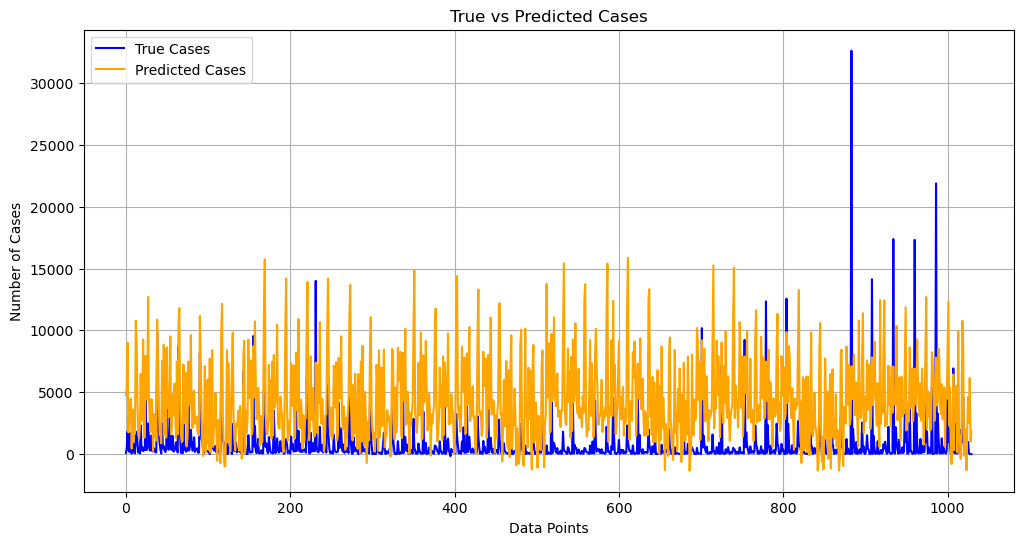

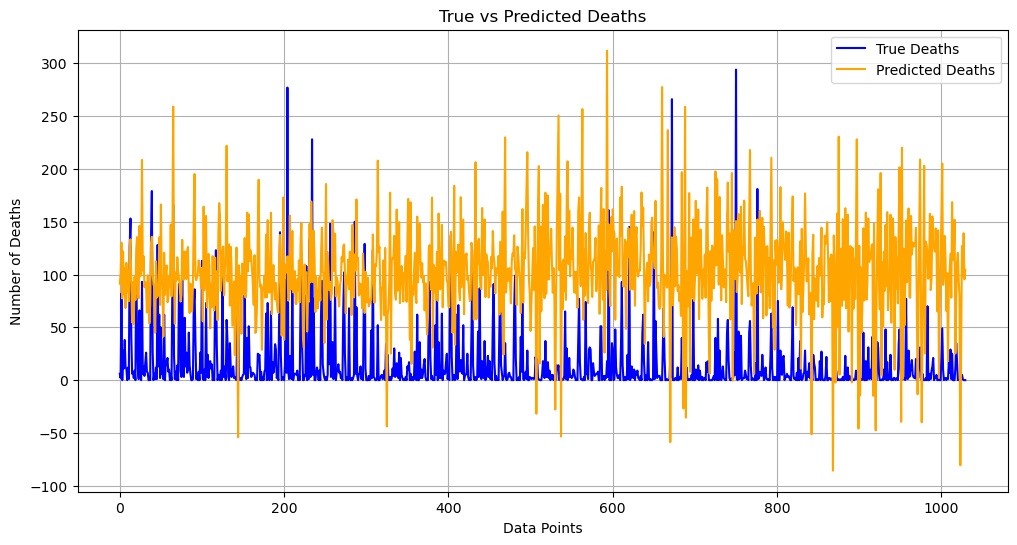

Evaluation completed. Metrics and plots saved.


In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load prediction results
results = pd.read_excel("Urban-Computing/prediction_results.xlsx")

# Extract true and predicted values for evaluation
true_cases = results['True_Cases'].values
pred_cases = results['Pred_Cases'].values
true_deaths = results['True_Deaths'].values
pred_deaths = results['Pred_Deaths'].values

# Compute evaluation metrics for cases
rmse_cases = np.sqrt(mean_squared_error(true_cases, pred_cases))
mae_cases = mean_absolute_error(true_cases, pred_cases)
r2_cases = r2_score(true_cases, pred_cases)

# Compute evaluation metrics for deaths
rmse_deaths = np.sqrt(mean_squared_error(true_deaths, pred_deaths))
mae_deaths = mean_absolute_error(true_deaths, pred_deaths)
r2_deaths = r2_score(true_deaths, pred_deaths)

# Display metrics
print("Cases Predictions Evaluation:")
print(f"RMSE: {rmse_cases:.2f}")
print(f"MAE: {mae_cases:.2f}")
print(f"R2: {r2_cases:.2f}")

print("\nDeaths Predictions Evaluation:")
print(f"RMSE: {rmse_deaths:.2f}")
print(f"MAE: {mae_deaths:.2f}")
print(f"R2: {r2_deaths:.2f}")

# Plot ground truth vs predictions for cases
plt.figure(figsize=(12, 6))
plt.plot(true_cases, label="True Cases", color="blue")
plt.plot(pred_cases, label="Predicted Cases", color="orange")
plt.title("True vs Predicted Cases")
plt.xlabel("Data Points")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.savefig("Urban-Computing/cases_predictions_comparison.png")
plt.show()

# Plot ground truth vs predictions for deaths
plt.figure(figsize=(12, 6))
plt.plot(true_deaths, label="True Deaths", color="blue")
plt.plot(pred_deaths, label="Predicted Deaths", color="orange")
plt.title("True vs Predicted Deaths")
plt.xlabel("Data Points")
plt.ylabel("Number of Deaths")
plt.legend()
plt.grid(True)
plt.savefig("Urban-Computing/deaths_predictions_comparison.png")
plt.show()

# Save metrics to a file
metrics_results = {
    "Cases": {
        "RMSE": rmse_cases,
        "MAE": mae_cases,
        "R2": r2_cases
    },
    "Deaths": {
        "RMSE": rmse_deaths,
        "MAE": mae_deaths,
        "R2": r2_deaths
    }
}

with open("Urban-Computing/baseline_evaluation_metrics.txt", "w") as f:
    for key, metrics in metrics_results.items():
        f.write(f"{key} Predictions Evaluation:\n")
        for metric, value in metrics.items():
            f.write(f"{metric}: {value:.2f}\n")
        f.write("\n")

print("Evaluation completed. Metrics and plots saved.")


### Cell-5: 

In [3]:
# Import necessary libraries
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_absolute_error as mae_scorer
from skmultiflow.drift_detection import ADWIN, DDM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import logging
from tqdm import tqdm

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Starting adaptive drift model training with progress tracking...")

# Load preprocessed data
data = pd.read_excel("Urban-Computing/train_data.xlsx")

# Feature engineering: Add rolling averages and lags for time series data
data['Cases_RollingMean'] = data['Cases'].rolling(window=7).mean().fillna(method='bfill')
data['Deaths_RollingMean'] = data['Deaths'].rolling(window=7).mean().fillna(method='bfill')
data['Cases_Lag'] = data['Cases'].shift(1).fillna(0)
data['Deaths_Lag'] = data['Deaths'].shift(1).fillna(0)

# Extract features and target variables
features = data.drop(columns=['Date', 'Country', 'Cases', 'Deaths'])
target_cases = data['Cases']
target_deaths = data['Deaths']

# Split data into training and testing sets
X_train, X_test, y_train_cases, y_test_cases = train_test_split(features, target_cases, test_size=0.3, shuffle=False)
X_train, X_test, y_train_deaths, y_test_deaths = train_test_split(features, target_deaths, test_size=0.3, shuffle=False)

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize drift detectors
adwin_cases = ADWIN()
adwin_deaths = ADWIN()
ddm_cases = DDM()
ddm_deaths = DDM()

# Initialize adaptive AutoML regressors
model_cases = AutoSklearnRegressor(
    time_left_for_this_task=10800,
    per_run_time_limit=600,
    n_jobs=1,
    memory_limit=20480,
    metric=mae_scorer,
    ensemble_size=50
)

model_deaths = AutoSklearnRegressor(
    time_left_for_this_task=10800,
    per_run_time_limit=600,
    n_jobs=1,
    memory_limit=20480,
    metric=mae_scorer,
    ensemble_size=50
)

# Adaptive model training function
def adaptive_train(model, X_train, y_train, X_test, y_test, adwin, ddm, label):
    logging.info(f"Training adaptive model for {label} with progress tracking...")
    predictions = []
    true_values = []
    model.fit(X_train, y_train)  # Initial training

    with tqdm(total=len(X_test), desc=f"Adaptive Training {label.title()}", unit="samples") as pbar:
        for i in range(len(X_test)):
            # Predict current sample
            X_sample = X_test[i].reshape(1, -1)
            y_sample = y_test[i]
            pred = model.predict(X_sample)[0]
            predictions.append(pred)
            true_values.append(y_sample)

            # Calculate error and add to drift detectors
            error = abs(y_sample - pred)
            adwin.add_element(error)
            ddm.add_element(error)

            # Check for drift and retrain if necessary
            if adwin.detected_change() or ddm.detected_change():
                logging.warning(f"Drift detected in {label} at index {i}. Retraining...")
                retrain_data_X = X_train_scaled[:i + 1]  # Use data up to current point
                retrain_data_y = y_train[:i + 1]
                model.fit(retrain_data_X, retrain_data_y)

            pbar.update(1)  # Update progress bar

    return np.array(predictions), np.array(true_values)

# Train adaptive models for cases and deaths
pred_cases, true_cases = adaptive_train(model_cases, X_train_scaled, y_train_cases.values, X_test_scaled, y_test_cases.values, adwin_cases, ddm_cases, "cases")
pred_deaths, true_deaths = adaptive_train(model_deaths, X_train_scaled, y_train_deaths.values, X_test_scaled, y_test_deaths.values, adwin_deaths, ddm_deaths, "deaths")

# Evaluate adaptive models
logging.info("Evaluating adaptive model predictions...")
rmse_cases = np.sqrt(mean_squared_error(true_cases, pred_cases))
mae_cases = mean_absolute_error(true_cases, pred_cases)
r2_cases = r2_score(true_cases, pred_cases)

rmse_deaths = np.sqrt(mean_squared_error(true_deaths, pred_deaths))
mae_deaths = mean_absolute_error(true_deaths, pred_deaths)
r2_deaths = r2_score(true_deaths, pred_deaths)

logging.info(f"Cases Prediction - RMSE: {rmse_cases}, MAE: {mae_cases}, R2: {r2_cases}")
logging.info(f"Deaths Prediction - RMSE: {rmse_deaths}, MAE: {mae_deaths}, R2: {r2_deaths}")

# Save adaptive predictions and results
adaptive_results = pd.DataFrame({
    'Country': data['Country'][len(data) - len(y_test_cases):],
    'Date': data['Date'][len(data) - len(y_test_cases):],
    'True_Cases': true_cases,
    'Pred_Cases': pred_cases,
    'True_Deaths': true_deaths,
    'Pred_Deaths': pred_deaths
})

adaptive_results.to_excel("Urban-Computing/adaptive_predictions_results_tqdm.xlsx", index=False)
logging.info("Adaptive predictions and results saved successfully.")

/data/s4017633/env/uc/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `ensemble_size` has been deprecated, please use `ensemble_kwargs = {'ensemble_size': 50}`. Inserting `ensemble_size` into `ensemble_kwargs` for now. `ensemble_size` will be removed in auto-sklearn 0.16.
/data/s4017633/env/uc/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: `ensemble_size` has been deprecated, please use `ensemble_kwargs = {'ensemble_size': 50}`. Inserting `ensemble_size` into `ensemble_kwargs` for now. `ensemble_size` will be removed in auto-sklearn 0.16.
/data/s4017633/env/uc/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/data/s4017633/env/uc/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/data/s4017633/env/uc/lib/py

### Cell-6:

Adaptive Model - Cases Predictions Evaluation:
RMSE: 3128.65
MAE: 1775.07
R2: 0.27

Adaptive Model - Deaths Predictions Evaluation:
RMSE: 94.99
MAE: 61.38
R2: -0.63


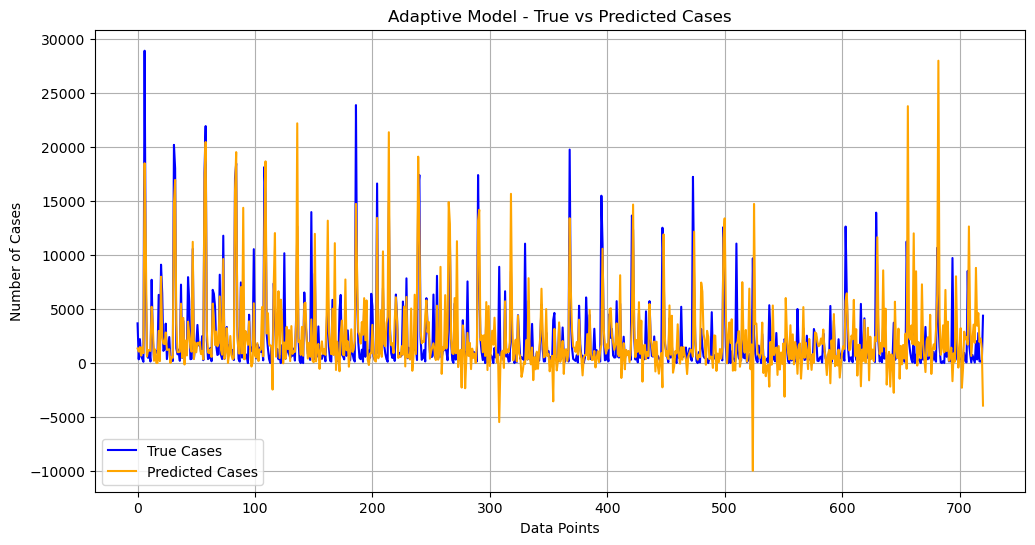

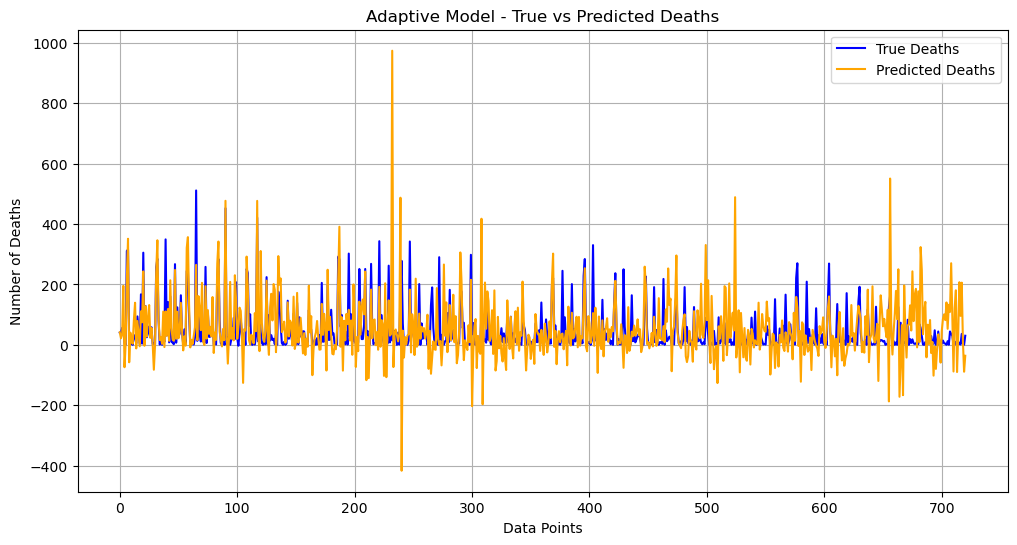

Adaptive model evaluation completed. Metrics and plots saved.


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load adaptive prediction results
adaptive_results = pd.read_excel("Urban-Computing/adaptive_predictions_results_tqdm.xlsx")

# Extract true and predicted values for evaluation
true_cases = adaptive_results['True_Cases'].values
pred_cases = adaptive_results['Pred_Cases'].values
true_deaths = adaptive_results['True_Deaths'].values
pred_deaths = adaptive_results['Pred_Deaths'].values

# Compute evaluation metrics for cases
rmse_cases = np.sqrt(mean_squared_error(true_cases, pred_cases))
mae_cases = mean_absolute_error(true_cases, pred_cases)
r2_cases = r2_score(true_cases, pred_cases)

# Compute evaluation metrics for deaths
rmse_deaths = np.sqrt(mean_squared_error(true_deaths, pred_deaths))
mae_deaths = mean_absolute_error(true_deaths, pred_deaths)
r2_deaths = r2_score(true_deaths, pred_deaths)

# Display metrics
print("Adaptive Model - Cases Predictions Evaluation:")
print(f"RMSE: {rmse_cases:.2f}")
print(f"MAE: {mae_cases:.2f}")
print(f"R2: {r2_cases:.2f}")

print("\nAdaptive Model - Deaths Predictions Evaluation:")
print(f"RMSE: {rmse_deaths:.2f}")
print(f"MAE: {mae_deaths:.2f}")
print(f"R2: {r2_deaths:.2f}")

# Plot ground truth vs predictions for cases
plt.figure(figsize=(12, 6))
plt.plot(true_cases, label="True Cases", color="blue")
plt.plot(pred_cases, label="Predicted Cases", color="orange")
plt.title("Adaptive Model - True vs Predicted Cases")
plt.xlabel("Data Points")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.savefig("Urban-Computing/adaptive_cases_predictions_comparison.png")
plt.show()

# Plot ground truth vs predictions for deaths
plt.figure(figsize=(12, 6))
plt.plot(true_deaths, label="True Deaths", color="blue")
plt.plot(pred_deaths, label="Predicted Deaths", color="orange")
plt.title("Adaptive Model - True vs Predicted Deaths")
plt.xlabel("Data Points")
plt.ylabel("Number of Deaths")
plt.legend()
plt.grid(True)
plt.savefig("Urban-Computing/adaptive_deaths_predictions_comparison.png")
plt.show()

# Save metrics to a file
adaptive_metrics_results = {
    "Cases": {
        "RMSE": rmse_cases,
        "MAE": mae_cases,
        "R2": r2_cases
    },
    "Deaths": {
        "RMSE": rmse_deaths,
        "MAE": mae_deaths,
        "R2": r2_deaths
    }
}

with open("Urban-Computing/adaptive_evaluation_metrics.txt", "w") as f:
    for key, metrics in adaptive_metrics_results.items():
        f.write(f"Adaptive Model - {key} Predictions Evaluation:\n")
        for metric, value in metrics.items():
            f.write(f"{metric}: {value:.2f}\n")
        f.write("\n")

print("Adaptive model evaluation completed. Metrics and plots saved.")


### Cell-7:

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load baseline and adaptive model results
baseline_results = pd.read_excel("Urban-Computing/prediction_results_updated.xlsx")
adaptive_results = pd.read_excel("Urban-Computing/adaptive_predictions_results_tqdm.xlsx")

# Extract evaluation metrics
baseline_metrics = pd.read_csv("baseline_evaluation_metrics.txt", sep=': ', engine='python', header=None, names=['Metric', 'Value'])
adaptive_metrics = pd.read_csv("adaptive_evaluation_metrics.txt", sep=': ', engine='python', header=None, names=['Metric', 'Value'])

# Extract true and predicted values
true_cases_baseline = baseline_results['True_Cases'].values
pred_cases_baseline = baseline_results['Pred_Cases'].values
true_cases_adaptive = adaptive_results['True_Cases'].values
pred_cases_adaptive = adaptive_results['Pred_Cases'].values

true_deaths_baseline = baseline_results['True_Deaths'].values
pred_deaths_baseline = baseline_results['Pred_Deaths'].values
true_deaths_adaptive = adaptive_results['True_Deaths'].values
pred_deaths_adaptive = adaptive_results['Pred_Deaths'].values

# Plot ground truth vs predictions for cases (Baseline vs Adaptive)
plt.figure(figsize=(12, 6))
plt.plot(true_cases_baseline, label="True Cases", color="blue")
plt.plot(pred_cases_baseline, label="Baseline Predictions", color="orange")
plt.plot(pred_cases_adaptive, label="Adaptive Predictions", color="green")
plt.title("Cases: Baseline vs Adaptive Predictions")
plt.xlabel("Data Points")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.savefig("Urban-Computing/cases_comparative_analysis.png")
plt.show()

# Plot ground truth vs predictions for deaths (Baseline vs Adaptive)
plt.figure(figsize=(12, 6))
plt.plot(true_deaths_baseline, label="True Deaths", color="blue")
plt.plot(pred_deaths_baseline, label="Baseline Predictions", color="orange")
plt.plot(pred_deaths_adaptive, label="Adaptive Predictions", color="green")
plt.title("Deaths: Baseline vs Adaptive Predictions")
plt.xlabel("Data Points")
plt.ylabel("Number of Deaths")
plt.legend()
plt.grid(True)
plt.savefig("Urban-Computing/deaths_comparative_analysis.png")
plt.show()

# Bar chart comparing RMSE values
rmse_values = {
    'Cases': [baseline_metrics.loc[baseline_metrics['Metric'] == 'RMSE', 'Value'].values[0],
              adaptive_metrics.loc[adaptive_metrics['Metric'] == 'RMSE', 'Value'].values[0]],
    'Deaths': [baseline_metrics.loc[baseline_metrics['Metric'] == 'RMSE', 'Value'].values[1],
               adaptive_metrics.loc[adaptive_metrics['Metric'] == 'RMSE', 'Value'].values[1]]
}

categories = list(rmse_values.keys())
baseline_rmse = [rmse_values[cat][0] for cat in categories]
adaptive_rmse = [rmse_values[cat][1] for cat in categories]

x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, baseline_rmse, width, label='Baseline')
plt.bar(x + width/2, adaptive_rmse, width, label='Adaptive')
plt.xticks(x, categories)
plt.ylabel("RMSE")
plt.title("Comparative RMSE Analysis")
plt.legend()
plt.grid(axis="y")
plt.savefig("rmse_comparative_analysis.png")
plt.show()

# Save comparison summary
comparison_summary = {
    "Baseline Metrics": baseline_metrics,
    "Adaptive Metrics": adaptive_metrics
}

with open("Urban-Computing/comparative_analysis_summary.txt", "w") as f:
    for key, metrics in comparison_summary.items():
        f.write(f"{key}:\n")
        f.write(metrics.to_string(index=False))
        f.write("\n\n")

print("Comparative analysis completed. Metrics and plots saved.")

FileNotFoundError: [Errno 2] No such file or directory: 'Urban-Computing/prediction_results_updated.xlsx'